In [3]:
# -*- coding: utf-8 -*-
"""
Batch Effect Analysis for GSE132044 Cortex Dataset
Using Harmony, scVI, BBKNN, Scanorama for batch intergration
Evaluation metrics are based on the Open Problems 
"""

# Cell 1: 导入必要的库\
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import mmread
import scanorama
import numpy as np
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from scipy.sparse.csgraph import connected_components
import warnings
warnings.filterwarnings('ignore')

os.chdir('D:/Columbia/Courses/Fall 2025/GR5243 APPLIED DATA SCIENCE/Final Project')

# Set plot style
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 100
sc.settings.set_figure_params(dpi=100, facecolor='white')
    

In [4]:
# Cell 2: 修正的数据加载函数 - 处理维度不匹配问题

def load_gse132044_data_correct():
    """正确加载 GSE132044 数据集，处理维度不匹配问题"""
    print("正在加载 GSE132044 数据集...")
    
    # 加载细胞元数据
    cells = pd.read_csv('GSE132044_cortex_mm10_cell.tsv.gz', sep='\t', index_col=0)
    print(f"细胞元数据形状: {cells.shape}")
    
    # 加载基因信息
    genes = pd.read_csv('GSE132044_cortex_mm10_gene.tsv.gz', sep='\t', header=None, names=['gene_ids'])
    print(f"基因数量: {len(genes)}")
    
    # 使用 mmread 加载 MTX 文件
    print("正在加载 MTX 表达矩阵...")
    counts = mmread('GSE132044_cortex_mm10_count_matrix.mtx.gz')
    print(f"原始 MTX 矩阵形状: {counts.shape} (基因 × 细胞)")
    
    # 转置为 cells × genes
    counts = counts.T.tocsr()
    print(f"转置后矩阵形状: {counts.shape} (细胞 × 基因)")
    
    # 检查维度是否匹配
    if counts.shape[0] != len(cells):
        print(f"警告: 表达矩阵细胞数 ({counts.shape[0]}) 与元数据细胞数 ({len(cells)}) 不匹配")
        print("将截断到较小的维度...")
        
        # 取较小的维度
        min_cells = min(counts.shape[0], len(cells))
        counts = counts[:min_cells, :]
        cells = cells.iloc[:min_cells]
        print(f"调整后: {min_cells} 个细胞")
    
    # 创建 AnnData 对象
    adata = sc.AnnData(X=counts)
    adata.obs = cells
    adata.var = genes.set_index('gene_ids')
    
    print(f"AnnData 对象创建完成: {adata.shape}")
    print(f"细胞数: {adata.n_obs}, 基因数: {adata.n_vars}")
    
    # 检查批次信息
    print("\n=== 检查批次信息 ===")
    # 从细胞名称中提取测序方法信息
    # 根据文件检查结果，细胞名称格式如: "Cortex1.Smart-seq2.p1_A1"
    method_info = adata.obs.index.str.split('.').str[1]
    adata.obs['method'] = method_info
    print(f"测序方法分布:\n{adata.obs['method'].value_counts()}")
    
    return adata

# 加载数据
adata = load_gse132044_data_correct()
adata

正在加载 GSE132044 数据集...
细胞元数据形状: (15174, 0)
基因数量: 28692
正在加载 MTX 表达矩阵...
原始 MTX 矩阵形状: (28692, 15175) (基因 × 细胞)
转置后矩阵形状: (15175, 28692) (细胞 × 基因)
警告: 表达矩阵细胞数 (15175) 与元数据细胞数 (15174) 不匹配
将截断到较小的维度...
调整后: 15174 个细胞
AnnData 对象创建完成: (15174, 28692)
细胞数: 15174, 基因数: 28692

=== 检查批次信息 ===
测序方法分布:
method
sci-RNA-seq        5830
10x-Chromium-v2    5571
DroNc-seq          3130
Smart-seq2          643
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 15174 × 28692
    obs: 'method'

In [5]:
# Cell 3: 数据预处理
def preprocess_adata(adata):
    """数据预处理流程"""
    print("开始数据预处理...")
    
    # 复制原始数据
    adata_processed = adata.copy()
    
    # 设置批次信息
    adata_processed.obs['batch'] = adata_processed.obs['method']
    print(f"批次信息: {adata_processed.obs['batch'].value_counts()}")
    
    # 1. 基本QC指标
    print("1. 计算QC指标...")
    # 小鼠线粒体基因通常以'mt-'开头（注意：基因名称格式为 ENSMUSG00000000001_Gnai3）
    # 我们需要从基因名称的第二部分（下划线后）检查是否以'mt-'开头
    gene_symbols = adata_processed.var_names.str.split('_').str[1]
    adata_processed.var['mt'] = gene_symbols.str.startswith('mt-')
    sc.pp.calculate_qc_metrics(
        adata_processed, 
        qc_vars=['mt'], 
        percent_top=None, 
        log1p=False, 
        inplace=True
    )
    
    # 2. 过滤细胞和基因
    print("2. 过滤低质量细胞和基因...")
    print(f"过滤前: {adata_processed.shape}")
    
    # 过滤低表达基因
    sc.pp.filter_genes(adata_processed, min_cells=3)
    
    # 过滤低质量细胞（基于基因数和线粒体比例）
    n_genes_threshold = 200
    mt_threshold = 20  # 线粒体基因比例阈值
    
    cell_filter = (adata_processed.obs['n_genes_by_counts'] >= n_genes_threshold) & \
                  (adata_processed.obs['pct_counts_mt'] <= mt_threshold)
    adata_processed = adata_processed[cell_filter, :]
    
    print(f"过滤后: {adata_processed.shape}")
    
    # 3. 标准化
    print("3. 数据标准化...")
    sc.pp.normalize_total(adata_processed, target_sum=1e4)
    sc.pp.log1p(adata_processed)
    
    # 4. 识别高变基因
    print("4. 识别高变基因...")
    sc.pp.highly_variable_genes(adata_processed, n_top_genes=2000)
    adata_processed.raw = adata_processed  # 保存原始数据
    
    # 使用高变基因
    adata_processed = adata_processed[:, adata_processed.var.highly_variable]
    
    # 5. 缩放和PCA
    print("5. 缩放数据和PCA...")
    sc.pp.scale(adata_processed, max_value=10)
    sc.tl.pca(adata_processed, svd_solver='arpack')
    
    print("数据预处理完成!")
    return adata_processed

# 执行预处理
adata_processed = preprocess_adata(adata)

开始数据预处理...
批次信息: batch
sci-RNA-seq        5830
10x-Chromium-v2    5571
DroNc-seq          3130
Smart-seq2          643
Name: count, dtype: int64
1. 计算QC指标...
2. 过滤低质量细胞和基因...
过滤前: (15174, 28692)
过滤后: (14931, 24735)
3. 数据标准化...
4. 识别高变基因...
5. 缩放数据和PCA...
数据预处理完成!


In [6]:
adata_processed.write('GSE132044_processed.h5ad')

=== 预处理后数据信息 ===
处理后的细胞数量: 14931
处理后的基因数量: 2000
批次信息:
batch
sci-RNA-seq        5600
10x-Chromium-v2    5558
DroNc-seq          3130
Smart-seq2          643
Name: count, dtype: int64

=== 可用的观测列 ===
['method', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt']


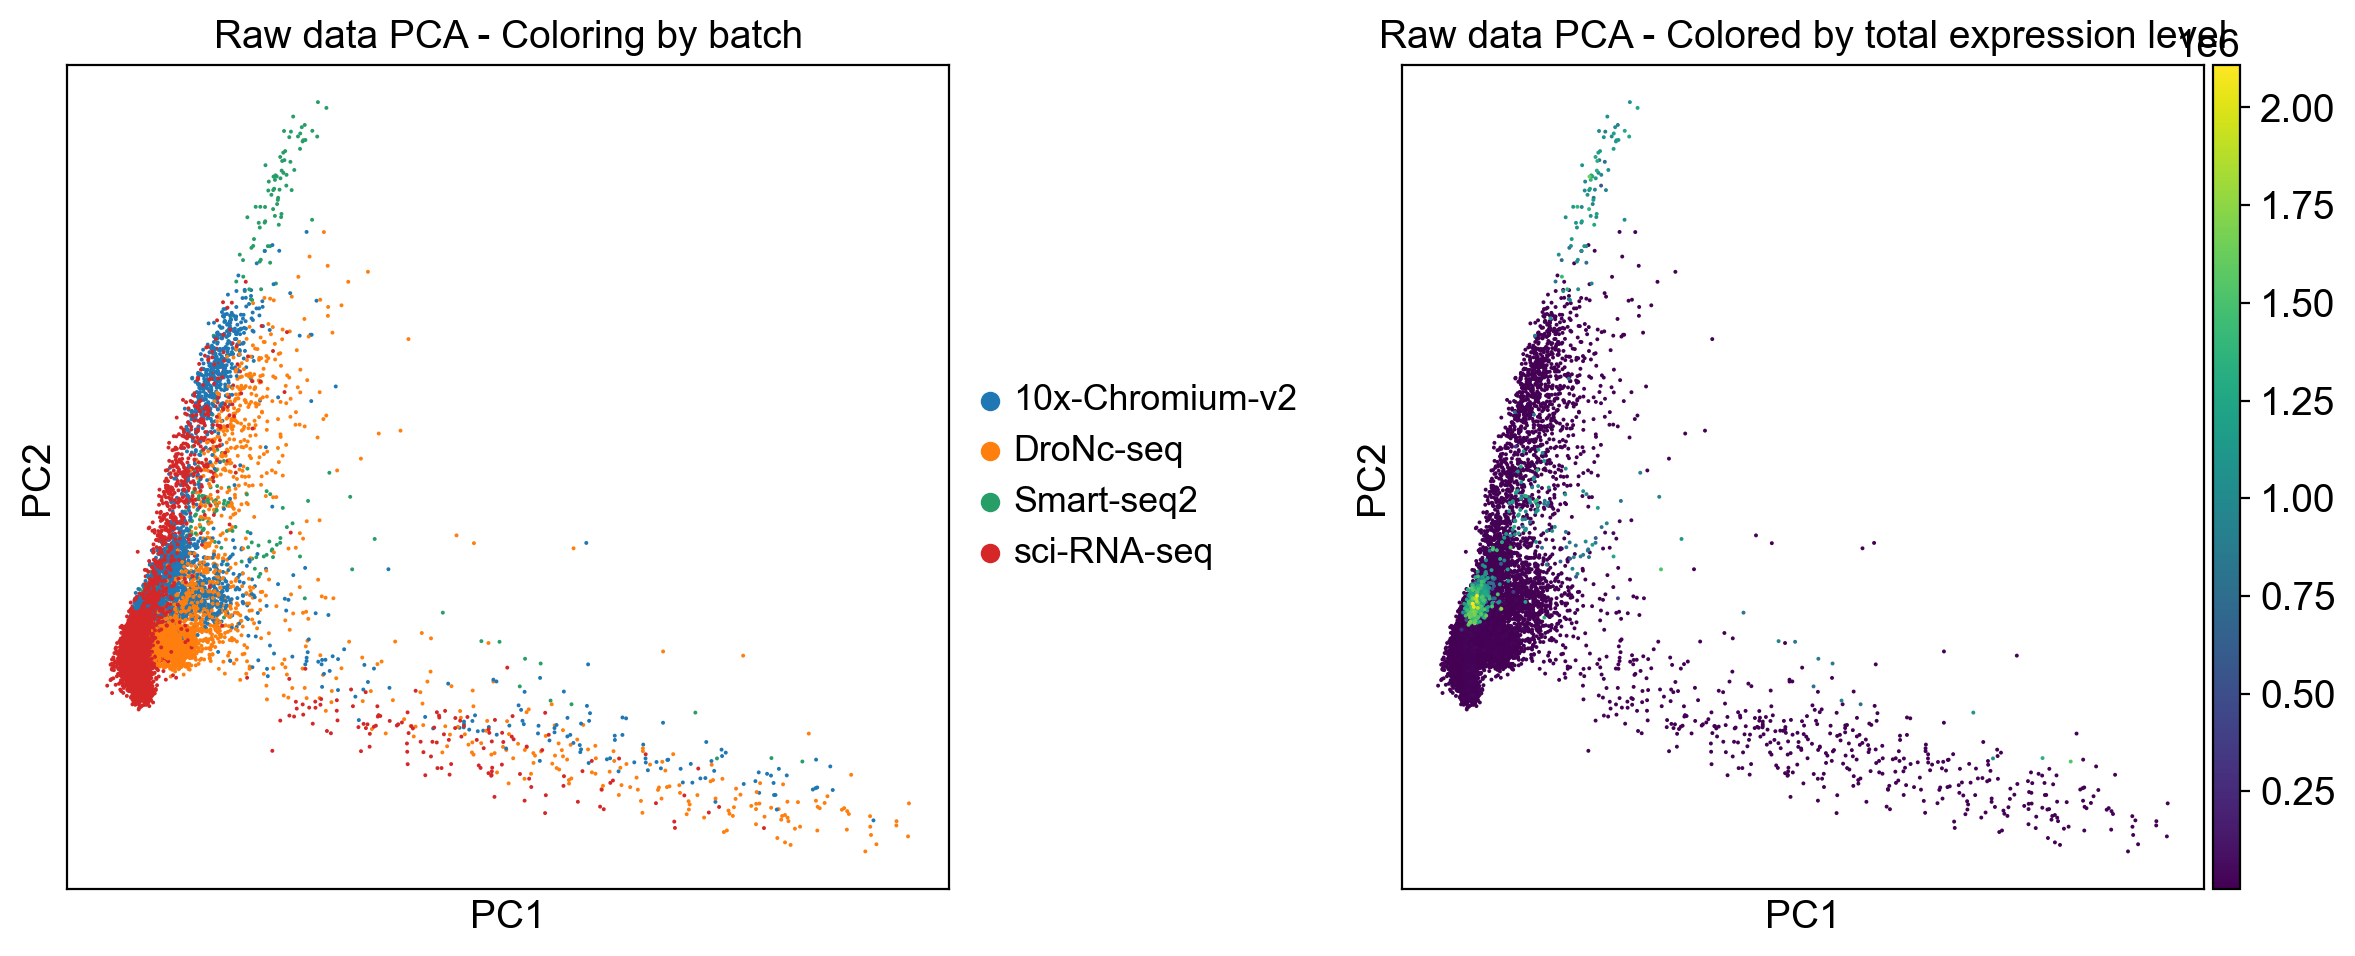


=== 批次效应初步分析 ===
Smart-seq2: PCA中心位置 = (1.47, 5.36)
10x-Chromium-v2: PCA中心位置 = (-0.13, 1.52)
DroNc-seq: PCA中心位置 = (3.75, -0.46)
sci-RNA-seq: PCA中心位置 = (-2.14, -1.87)


In [9]:
# Cell 4: 探索预处理后的数据
print("=== 预处理后数据信息 ===")
print(f"处理后的细胞数量: {adata_processed.n_obs}")
print(f"处理后的基因数量: {adata_processed.n_vars}")
print(f"批次信息:\n{adata_processed.obs['batch'].value_counts()}")

# 检查是否有其他可能的细胞类型信息
print("\n=== 可用的观测列 ===")
print(adata_processed.obs.columns.tolist())

# 可视化原始数据的PCA
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.pca(adata_processed, color=['batch'], ax=axes[0], show=False, title='Raw data PCA - Coloring by batch')
sc.pl.pca(adata_processed, color=['total_counts'], ax=axes[1], show=False, title='Raw data PCA - Colored by total expression level')
plt.tight_layout()
plt.show()

# 查看批次效应的强度
print("\n=== 批次效应初步分析 ===")
# 计算每个批次在PCA空间中的中心
batch_centers = {}
for batch in adata_processed.obs['batch'].unique():
    batch_mask = adata_processed.obs['batch'] == batch
    batch_center = np.mean(adata_processed.obsm['X_pca'][batch_mask, :2], axis=0)  # 前两个PC
    batch_centers[batch] = batch_center
    print(f"{batch}: PCA中心位置 = ({batch_center[0]:.2f}, {batch_center[1]:.2f})")

In [6]:
# Cell 5: 简化的评估指标函数
def compute_comprehensive_metrics_simple(adata, batch_key='batch', label_key=None, use_cluster_as_label=True):
    """
    使用简化的评估指标计算批次效应校正效果（不依赖 scIB 包）
    """
    metrics = {}
    
    # 确保有邻居图
    if 'neighbors' not in adata.uns:
        print("计算邻居图...")
        sc.pp.neighbors(adata)
    
    # 如果没有提供标签键，使用聚类结果作为替代
    if label_key is None and use_cluster_as_label:
        # 确保有聚类结果
        if 'leiden' not in adata.obs.columns:
            print("计算Leiden聚类...")
            sc.tl.leiden(adata, resolution=0.5)
        label_key = 'leiden'
        print(f"使用聚类结果作为标签: {label_key}")
    
    # 使用前20个PC进行计算
    if adata.obsm['X_pca'].shape[1] > 20:
        X_emb = adata.obsm['X_pca'][:, :20]
    else:
        X_emb = adata.obsm['X_pca']
    
    # 1. 批次轮廓宽度 (ASW batch) - 越小越好
    try:
        if len(adata.obs[batch_key].unique()) > 1:
            batch_silhouette = silhouette_score(X_emb, adata.obs[batch_key])
            metrics['ASW_batch'] = batch_silhouette
        else:
            metrics['ASW_batch'] = np.nan
    except Exception as e:
        print(f"ASW_batch计算失败: {e}")
        metrics['ASW_batch'] = np.nan
    
    # 2. 批次混合的局部逆辛普森指数 (ILISI) - 越大越好
    try:
        # 计算k近邻
        n_neighbors = min(50, X_emb.shape[0] - 1)
        nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X_emb)
        distances, indices = nbrs.kneighbors(X_emb)
        
        # 计算每个细胞的LISI分数
        lisi_scores = []
        for i in range(X_emb.shape[0]):
            neighbor_batches = adata.obs[batch_key].iloc[indices[i]].values
            unique, counts = np.unique(neighbor_batches, return_counts=True)
            proportions = counts / len(neighbor_batches)
            simpson = np.sum(proportions ** 2)
            lisi = 1 / simpson if simpson > 0 else 0
            lisi_scores.append(lisi)
        
        metrics['ILISI'] = np.mean(lisi_scores) / 4
    except Exception as e:
        print(f"ILISI计算失败: {e}")
        metrics['ILISI'] = np.nan
    
    # 3. 主成分回归批次方差 (PCR) - 越小越好
    try:
        # 使用前10个PC
        X_pca = adata.obsm['X_pca'][:, :10]
        
        # 编码批次信息
        le = LabelEncoder()
        batch_encoded = le.fit_transform(adata.obs[batch_key])
        
        # 计算每个PC与批次的相关性
        r2_scores = []
        for i in range(X_pca.shape[1]):
            model = LinearRegression()
            model.fit(X_pca[:, i].reshape(-1, 1), batch_encoded)
            y_pred = model.predict(X_pca[:, i].reshape(-1, 1))
            r2 = 1 - np.sum((batch_encoded - y_pred) ** 2) / np.sum((batch_encoded - np.mean(batch_encoded)) ** 2)
            r2_scores.append(r2)
        
        metrics['PCR'] = np.mean(r2_scores)
    except Exception as e:
        print(f"PCR计算失败: {e}")
        metrics['PCR'] = np.nan
    
    # 4. 图连通性 (Graph Connectivity) - 越大越好
    try:
        connectivity_scores = []
        for cluster in adata.obs[label_key].unique():
            cluster_mask = adata.obs[label_key] == cluster
            if cluster_mask.sum() > 1:  # 至少有两个细胞
                # 获取该聚类的子图
                sub_adj = adata.obsp['connectivities'][cluster_mask, :][:, cluster_mask]
                # 计算连通分量
                n_components, _ = connected_components(sub_adj)
                # 连通性 = 1 - (连通分量数 - 1) / (细胞数 - 1)
                connectivity = 1.0 - (n_components - 1) / (cluster_mask.sum() - 1)
                connectivity_scores.append(connectivity)
        
        metrics['Graph_connectivity'] = np.mean(connectivity_scores) if connectivity_scores else 0
    except Exception as e:
        print(f"Graph_connectivity计算失败: {e}")
        metrics['Graph_connectivity'] = np.nan
    
    # 5. k近邻批次效应检验 (KBET) - 越小越好
    try:
        # 简化的kBET实现
        # 计算每个细胞的k近邻中不同批次的比例
        n_neighbors = min(30, X_emb.shape[0] - 1)
        nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X_emb)
        distances, indices = nbrs.kneighbors(X_emb)
        
        batch_rejection_rates = []
        for i in range(X_emb.shape[0]):
            neighbor_batches = adata.obs[batch_key].iloc[indices[i]].values
            # 计算当前细胞的批次
            cell_batch = adata.obs[batch_key].iloc[i]
            # 计算邻居中相同批次的比例
            same_batch_ratio = np.sum(neighbor_batches == cell_batch) / len(neighbor_batches)
            # 如果比例低于阈值，则拒绝
            threshold = 1 / len(adata.obs[batch_key].unique())
            if same_batch_ratio < threshold:
                batch_rejection_rates.append(1)
            else:
                batch_rejection_rates.append(0)
        
        metrics['KBET'] = np.mean(batch_rejection_rates) if batch_rejection_rates else 0
    except Exception as e:
        print(f"KBET计算失败: {e}")
        metrics['KBET'] = np.nan
    
    # 6. 调整兰德指数 (ARI) - 越大越好
    try:
        if label_key is not None:
            # 使用聚类结果与自身比较（在没有真实标签的情况下）
            # 在这种情况下，ARI总是1，所以跳过
            metrics['ARI'] = np.nan
        else:
            metrics['ARI'] = np.nan
    except Exception as e:
        print(f"ARI计算失败: {e}")
        metrics['ARI'] = np.nan
    
    # 7. 细胞类型轮廓宽度 (ASW Label) - 越大越好
    try:
        if label_key is not None and len(adata.obs[label_key].unique()) > 1:
            label_silhouette = silhouette_score(X_emb, adata.obs[label_key])
            metrics['ASW_label'] = label_silhouette
        else:
            metrics['ASW_label'] = np.nan
    except Exception as e:
        print(f"ASW_label计算失败: {e}")
        metrics['ASW_label'] = np.nan
    
    # 8. 细胞类型局部逆辛普森指数 (cLISI) - 越大越好
    try:
        if label_key is not None:
            # 计算k近邻
            n_neighbors = min(50, X_emb.shape[0] - 1)
            nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X_emb)
            distances, indices = nbrs.kneighbors(X_emb)
            
            # 计算每个细胞的cLISI分数
            clisi_scores = []
            for i in range(X_emb.shape[0]):
                neighbor_labels = adata.obs[label_key].iloc[indices[i]].values
                unique, counts = np.unique(neighbor_labels, return_counts=True)
                proportions = counts / len(neighbor_labels)
                simpson = np.sum(proportions ** 2)
                clisi = 1 / simpson if simpson > 0 else 0
                clisi_scores.append(clisi)
            
            metrics['cLISI'] = np.mean(clisi_scores) / 4
        else:
            metrics['cLISI'] = np.nan
    except Exception as e:
        print(f"cLISI计算失败: {e}")
        metrics['cLISI'] = np.nan
    
    # 9. 标准化互信息 (NMI) - 越大越好
    try:
        if label_key is not None:
            # 使用聚类结果与自身比较（在没有真实标签的情况下）
            # 在这种情况下，NMI总是1，所以跳过
            metrics['NMI'] = np.nan
        else:
            metrics['NMI'] = np.nan
    except Exception as e:
        print(f"NMI计算失败: {e}")
        metrics['NMI'] = np.nan
    
    # 10. 细胞周期保守性 (Cell Cycle Conservation) - 越大越好
    try:
        # 需要细胞周期分数，这里跳过
        metrics['Cell_cycle_conservation'] = np.nan
        print("跳过细胞周期保守性计算（需要细胞周期分数）")
    except Exception as e:
        print(f"Cell_cycle_conservation计算失败: {e}")
        metrics['Cell_cycle_conservation'] = np.nan
    
    return metrics

In [12]:
# 计算原始数据的指标
print("计算原始数据的批次效应指标...")
original_metrics = compute_comprehensive_metrics_simple(adata_processed)
print("原始数据指标:")
for k, v in original_metrics.items():
    if not pd.isna(v):
        print(f"  {k}: {v:.4f}")

计算原始数据的批次效应指标...
计算邻居图...
计算Leiden聚类...
使用聚类结果作为标签: leiden
跳过细胞周期保守性计算（需要细胞周期分数）
原始数据指标:
  ASW_batch: 0.1539
  ILISI: 0.2614
  PCR: 0.0808
  Graph_connectivity: 1.0000
  KBET: 0.0028
  ASW_label: 0.2477
  cLISI: 0.2850


运行 Harmony 批次校正...


2025-11-25 01:12:37,512 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-25 01:12:40,217 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-25 01:12:40,363 - harmonypy - INFO - Iteration 1 of 10
2025-11-25 01:12:47,312 - harmonypy - INFO - Iteration 2 of 10
2025-11-25 01:12:53,848 - harmonypy - INFO - Iteration 3 of 10
2025-11-25 01:13:00,078 - harmonypy - INFO - Iteration 4 of 10
2025-11-25 01:13:06,342 - harmonypy - INFO - Iteration 5 of 10
2025-11-25 01:13:12,388 - harmonypy - INFO - Converged after 5 iterations


Harmony 完成!


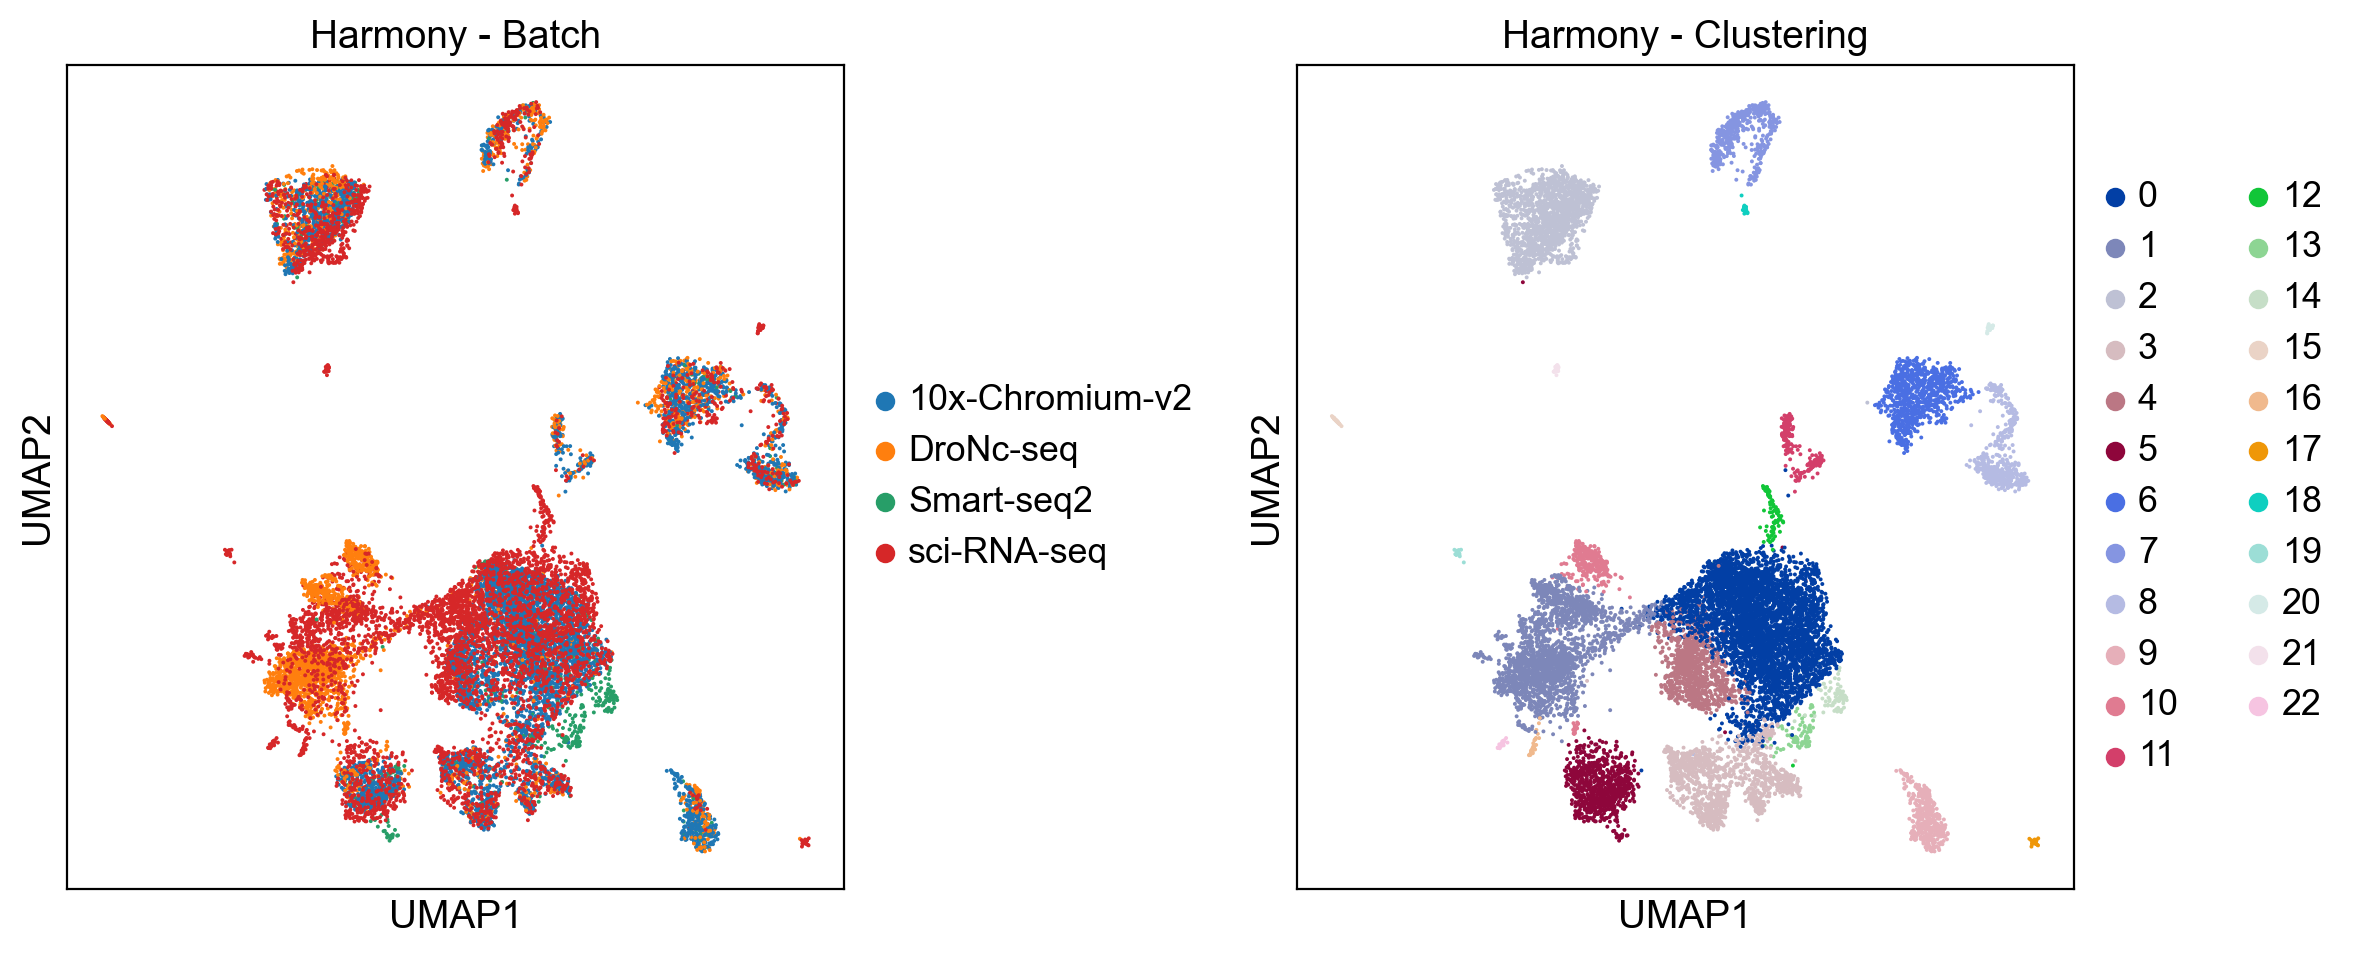

使用聚类结果作为标签: leiden
跳过细胞周期保守性计算（需要细胞周期分数）
Harmony 校正后指标:
  ASW_batch: -0.0178
  ILISI: 0.4253
  PCR: 0.0061
  Graph_connectivity: 1.0000
  KBET: 0.1181
  ASW_label: 0.1440
  cLISI: 0.3117


In [7]:
# Cell 6: Harmony 批次校正
def run_harmony_integration(adata):
    """运行 Harmony 批次校正"""
    print("运行 Harmony 批次校正...")
    
    adata_harmony = adata.copy()
    
    # 确保有邻居图
    if 'neighbors' not in adata_harmony.uns:
        sc.pp.neighbors(adata_harmony)
    
    # 运行 Harmony
    sc.external.pp.harmony_integrate(adata_harmony, key='batch', basis='X_pca')
    
    # 使用 Harmony 校正后的PCA进行后续分析
    adata_harmony.obsm['X_pca_original'] = adata_harmony.obsm['X_pca'].copy()
    adata_harmony.obsm['X_pca'] = adata_harmony.obsm['X_pca_harmony']
    
    # 重新计算邻居图和UMAP
    sc.pp.neighbors(adata_harmony, use_rep='X_pca')
    sc.tl.umap(adata_harmony)
    
    # 确保有聚类结果
    if 'leiden' not in adata_harmony.obs.columns:
        sc.tl.leiden(adata_harmony, resolution=0.5)
    
    print("Harmony 完成!")
    return adata_harmony

# 运行 Harmony
adata_harmony = run_harmony_integration(adata_processed)

# 可视化 Harmony 结果
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.umap(adata_harmony, color=['batch'], ax=axes[0], show=False, title='Harmony - Batch')
sc.pl.umap(adata_harmony, color=['leiden'], ax=axes[1], show=False, title='Harmony - Clustering')
plt.tight_layout()
plt.show()

# 计算 Harmony 后的指标
harmony_metrics = compute_comprehensive_metrics_simple(adata_harmony)
print("Harmony 校正后指标:")
for k, v in harmony_metrics.items():
    if not pd.isna(v):
        print(f"  {k}: {v:.4f}")

In [ ]:


# Cell 8: scVI 批次校正
def run_scvi_integration(adata):
    """运行 scVI 批次校正"""
    print("运行 scVI 批次校正...")
    
    adata_scvi = adata.copy()
    
    # 确保批次信息是分类变量
    adata_scvi.obs['batch'] = adata_scvi.obs['batch'].astype('category')
    
    # 设置 scVI 数据
    scvi.model.SCVI.setup_anndata(adata_scvi, batch_key='batch')
    
    # 创建和训练模型（使用较小的网络以减少内存使用）
    vae = scvi.model.SCVI(adata_scvi, n_layers=2, n_latent=30, gene_likelihood='nb')
    
    print("训练 scVI 模型...（这可能需要一些时间）")
    vae.train(max_epochs=50, early_stopping=True)  # 减少训练轮数
    
    # 获取潜在表示
    adata_scvi.obsm['X_scVI'] = vae.get_latent_representation()
    
    # 使用 scVI 潜在表示进行UMAP
    adata_scvi.obsm['X_pca_original'] = adata_scvi.obsm['X_pca'].copy()
    adata_scvi.obsm['X_pca'] = adata_scvi.obsm['X_scVI']
    
    # 重新计算邻居图和UMAP
    sc.pp.neighbors(adata_scvi, use_rep='X_pca')
    sc.tl.umap(adata_scvi)
    
    print("scVI 完成!")
    return adata_scvi

# 运行 scVI（如果内存允许）
try:
    adata_scvi = run_scvi_integration(adata_processed)
    
    # 可视化 scVI 结果
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sc.pl.umap(adata_scvi, color=['batch'], ax=axes[0], show=False, title='scVI - 批次')
    sc.pl.umap(adata_scvi, color=['leiden'], ax=axes[1], show=False, title='scVI - 聚类')
    plt.tight_layout()
    plt.show()
    
    # 计算 scVI 后的指标
    scvi_metrics = compute_comprehensive_metrics_simple(adata_scvi)
    print("scVI 校正后指标:")
    for k, v in scvi_metrics.items():
        print(f"  {k}: {v:.4f}")
        
except Exception as e:
    print(f"scVI 运行失败: {e}")
    print("跳过 scVI 分析")
    adata_scvi = None
    scvi_metrics = {}

AttributeError: partially initialized module 'jax' has no attribute 'version' (most likely due to a circular import)

In [5]:
# 检查数据状态和内存使用
def check_data_status(adata):
    """检查数据状态"""
    print("数据状态检查:")
    print(f"  细胞数: {adata.n_obs}")
    print(f"  基因数: {adata.n_vars}")
    print(f"  批次数: {adata.obs['batch'].nunique()}")
    print(f"  内存使用: {adata.n_obs * adata.n_vars * 4 / 1024**2:.2f} MB (估计)")
    
    # 检查是否有过多的零
    zero_ratio = (adata.X == 0).mean() if hasattr(adata.X, 'shape') else None
    if zero_ratio is not None:
        print(f"  零值比例: {zero_ratio:.2%}")

# 运行检查
check_data_status(adata_processed)

# 如果数据太大，考虑子采样
def subsample_data(adata, n_cells=20000, random_state=42):
    """对数据进行子采样"""
    if adata.n_obs <= n_cells:
        return adata
    
    print(f"对数据进行子采样: {adata.n_obs} -> {n_cells} 细胞")
    
    # 按批次平衡采样
    sc.pp.subsample(adata, n_obs=n_cells, random_state=random_state)
    return adata

# 如果数据太大，进行子采样
if adata_processed.n_obs > 30000:
    adata_subsampled = subsample_data(adata_processed.copy(), n_cells=20000)
else:
    adata_subsampled = adata_processed.copy()

# 然后使用子采样数据运行 BBKNN

数据状态检查:
  细胞数: 14931
  基因数: 2000
  批次数: 4
  内存使用: 113.91 MB (估计)
  零值比例: 0.00%


In [8]:
import scanpy as sc
import bbknn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def run_bbknn_safe(adata, batch_key='batch'):
    """安全运行 BBKNN，避免内核崩溃"""
    print("安全运行 BBKNN...")
    
    adata_bbknn = adata.copy()
    
    try:
        # 方法1：使用 bbknn 包的独立函数
        bbknn.bbknn(adata_bbknn, batch_key=batch_key, n_pcs=30, neighbors_within_batch=3, approx=False)
        
        # 计算 UMAP
        sc.tl.umap(adata_bbknn)
        
        # 确保有聚类结果
        if 'leiden' not in adata_bbknn.obs.columns:
            sc.tl.leiden(adata_bbknn, resolution=0.5)
        
        print("BBKNN 安全模式完成!")
        return adata_bbknn
        
    except Exception as e:
        print(f"方法1失败: {e}")
        
        try:
            # 方法2：使用 scanpy 外部工具但强制精确计算
            sc.external.pp.bbknn(adata_bbknn, batch_key=batch_key, n_pcs=20, neighbors_within_batch=2, metric='euclidean')
            
            sc.tl.umap(adata_bbknn)
            if 'leiden' not in adata_bbknn.obs.columns:
                sc.tl.leiden(adata_bbknn, resolution=0.5)
                
            print("BBKNN 方法2完成!")
            return adata_bbknn
            
        except Exception as e2:
            print(f"所有BBKNN方法都失败: {e2}")
            return None

# 运行安全版本的 BBKNN
adata_bbknn = run_bbknn_safe(adata_processed)

安全运行 BBKNN...
BBKNN 安全模式完成!


In [9]:
# 计算 BBKNN 后的指标
bbknn_metrics = compute_comprehensive_metrics_simple(adata_bbknn)
print("BBKNN 校正后指标:")
for k, v in bbknn_metrics.items():
    if not pd.isna(v):
        print(f"  {k}: {v:.4f}")

使用聚类结果作为标签: leiden
跳过细胞周期保守性计算（需要细胞周期分数）
BBKNN 校正后指标:
  ASW_batch: 0.1539
  ILISI: 0.2614
  PCR: 0.0808
  Graph_connectivity: 1.0000
  KBET: 0.0028
  ASW_label: 0.1775
  cLISI: 0.3014


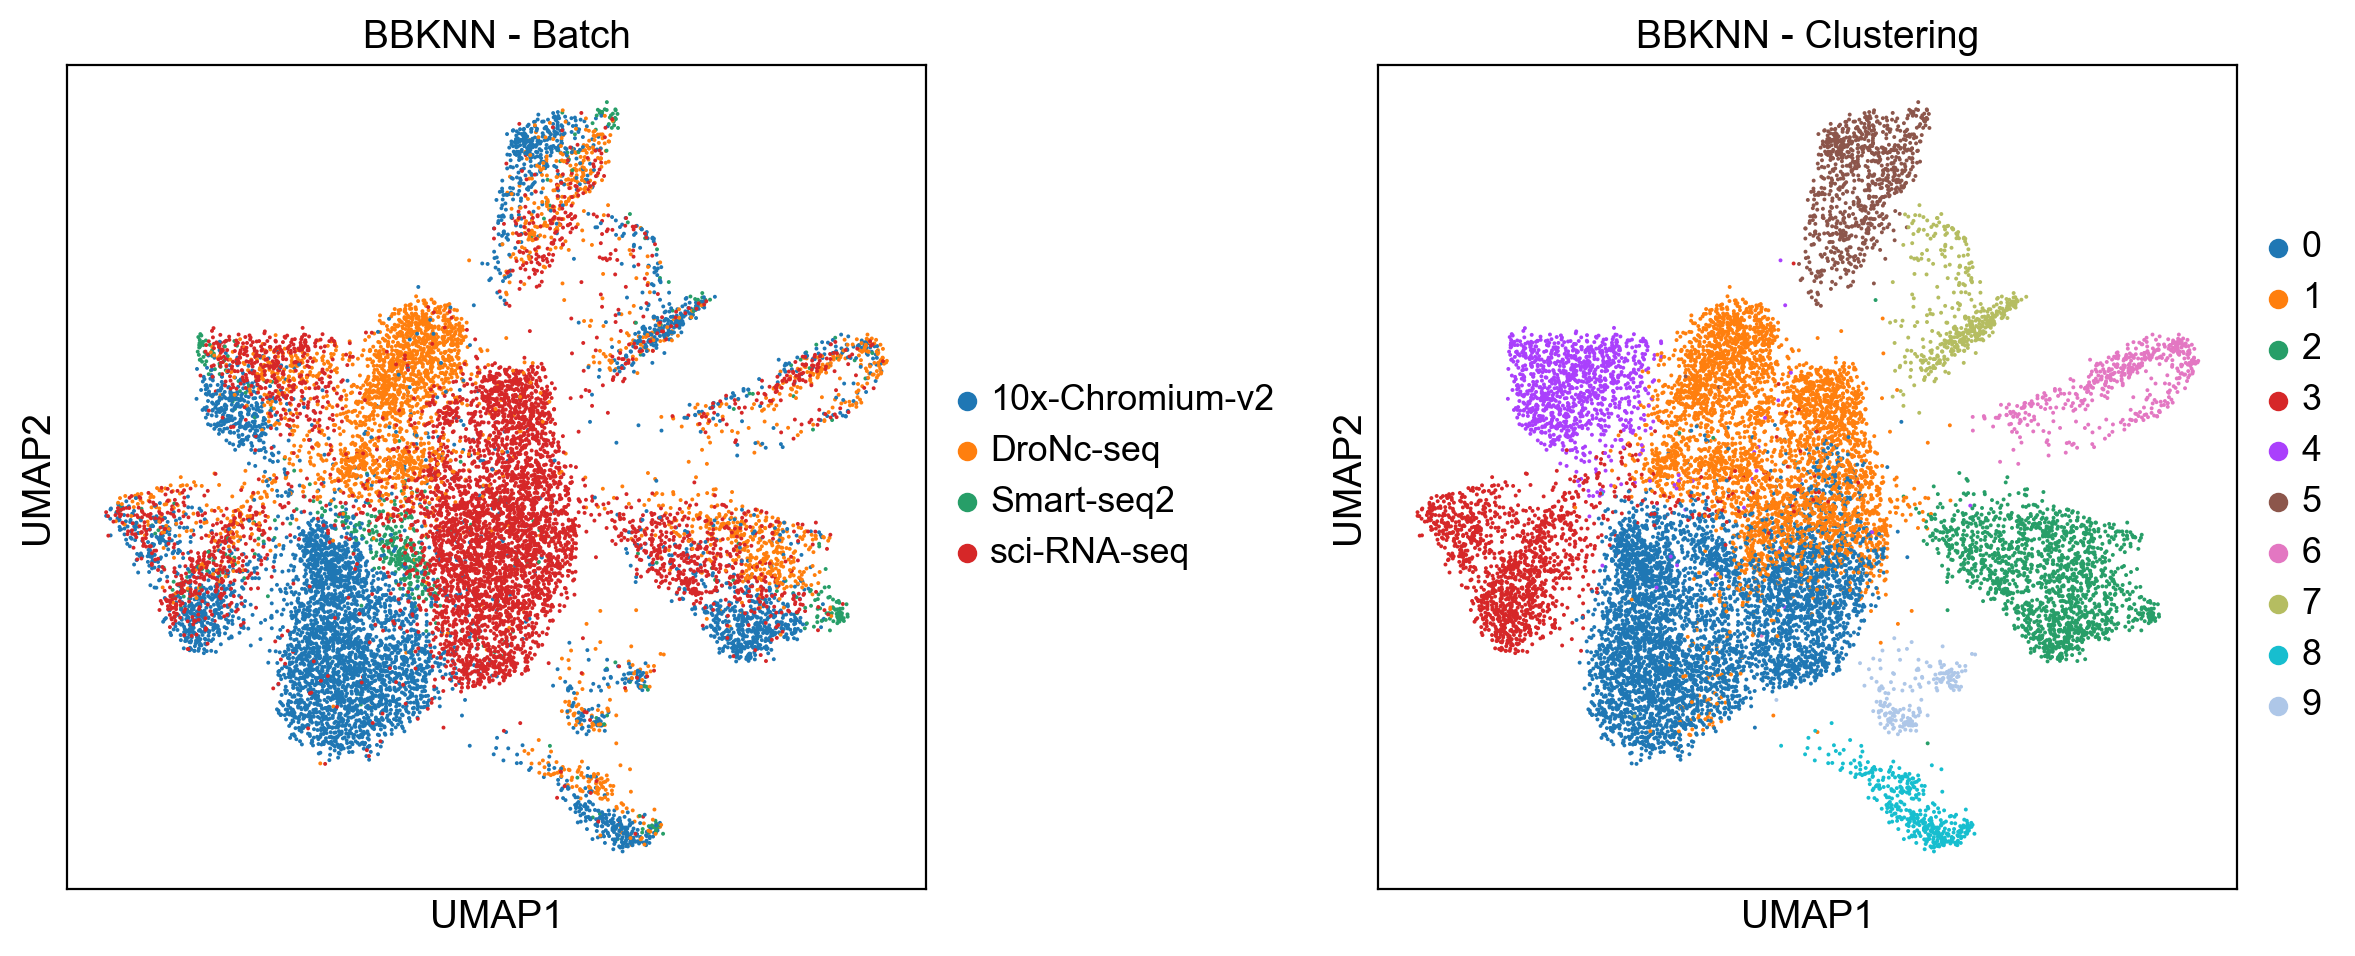

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.umap(adata_bbknn, color=['batch'], ax=axes[0], show=False, title='BBKNN - Batch')
sc.pl.umap(adata_bbknn, color=['leiden'], ax=axes[1], show=False, title='BBKNN - Clustering')
plt.tight_layout()
plt.show()

In [6]:
# Cell 10: 修复 Scanorama 批次连续性问题
def run_scanorama_integration_fixed(adata):
    """运行 Scanorama 批次校正（修复版本）"""
    print("运行 Scanorama 批次校正（修复版本）...")
    
    adata_scanorama = adata.copy()
    
    try:
        # 确保批次是连续的
        print("检查批次连续性...")
        batches = adata_scanorama.obs['batch'].astype('category').cat.codes
        print(f"批次代码: {batches.unique()}")
        
        # 方法1：使用 Scanpy 内置函数但确保批次连续
        sc.external.pp.scanorama_integrate(adata_scanorama, key='batch')
        
        # 使用校正后的嵌入
        sc.pp.neighbors(adata_scanorama, use_rep='X_scanorama')
        sc.tl.umap(adata_scanorama)
        
        # 聚类
        sc.tl.leiden(adata_scanorama, resolution=0.5)
        
        print("Scanorama 修复版本完成!")
        return adata_scanorama
        
    except Exception as e:
        print(f"Scanorama 修复版本失败: {e}")
        
        # 方法2：手动处理批次连续性问题
        print("尝试手动处理批次连续性问题...")
        try:
            return run_scanorama_manual(adata_scanorama)
        except Exception as e2:
            print(f"手动处理方法也失败: {e2}")
            return None

def run_scanorama_manual(adata):
    """手动处理 Scanorama 批次连续性问题"""
    import scanorama
    
    # 创建批次映射以确保连续性
    batch_labels = adata.obs['batch'].astype('category')
    batch_codes = batch_labels.cat.codes.values
    
    print(f"原始批次: {batch_labels.cat.categories.tolist()}")
    print(f"批次代码: {np.unique(batch_codes)}")
    
    # 按批次分割数据
    adatas_by_batch = []
    for batch in np.unique(batch_codes):
        batch_mask = batch_codes == batch
        batch_adata = adata[batch_mask].copy()
        adatas_by_batch.append(batch_adata)
    
    print(f"分割为 {len(adatas_by_batch)} 个批次")
    
    # 运行 Scanorama
    integrated = scanorama.integrate_scanpy(adatas_by_batch, return_dimred=True)
    
    # 合并校正后的数据
    adata_corrected = sc.concat(integrated)
    adata_corrected.obs = adata.obs.loc[adata_corrected.obs_names]
    
    # 使用 Scanorama 校正后的表示
    adata_corrected.obsm['X_scanorama'] = adata_corrected.obsm['X_pca']
    
    # 重新计算邻居图和UMAP
    sc.pp.neighbors(adata_corrected, use_rep='X_scanorama')
    sc.tl.umap(adata_corrected)
    sc.tl.leiden(adata_corrected, resolution=0.5)
    
    print("手动 Scanorama 完成!")
    return adata_corrected

# 运行修复版本的 Scanorama
adata_scanorama = run_scanorama_integration_fixed(adata_processed)

if adata_scanorama is not None:
    # 可视化 Scanorama 结果
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sc.pl.umap(adata_scanorama, color=['batch'], ax=axes[0], show=False, title='Scanorama - 批次')
    sc.pl.umap(adata_scanorama, color=['leiden'], ax=axes[1], show=False, title='Scanorama - 聚类')
    plt.tight_layout()
    plt.show()

    # 计算 Scanorama 后的指标
    scanorama_metrics = compute_comprehensive_metrics_simple(adata_scanorama)
    print("Scanorama 校正后指标:")
    for k, v in scanorama_metrics.items():
        if not pd.isna(v):
            print(f"  {k}: {v:.4f}")
            
    # 保存结果
    adata_scanorama.write('scanorama_integrated.h5ad', compression='gzip')
    print("Scanorama 结果已保存为 'scanorama_integrated.h5ad'")
else:
    print("Scanorama 运行失败，跳过该方法")

运行 Scanorama 批次校正（修复版本）...
检查批次连续性...
批次代码: [2 0 1 3]
Scanorama 修复版本失败: Detected non-contiguous batches.
尝试手动处理批次连续性问题...
原始批次: ['10x-Chromium-v2', 'DroNc-seq', 'Smart-seq2', 'sci-RNA-seq']
批次代码: [0 1 2 3]
分割为 4 个批次
手动处理方法也失败: integrate() got an unexpected keyword argument 'return_dimred'
Scanorama 运行失败，跳过该方法


In [ ]:
# Cell 10: Scanorama 批次校正
def run_scanorama_integration(adata):
    """运行 Scanorama 批次校正"""
    print("运行 Scanorama 批次校正...")
    
    adata_scanorama = adata.copy()
    
    # 按批次分割数据
    batches = adata_scanorama.obs['batch'].unique()
    adatas = [adata_scanorama[adata_scanorama.obs['batch'] == batch].copy() for batch in batches]
    
    # 运行 Scanorama
    integrated = scanorama.integrate_scanpy(adatas)
    
    # 合并校正后的数据
    adata_corrected = sc.concat(integrated)
    adata_corrected.obs = adata_scanorama.obs
    
    # 使用 Scanorama 校正后的表示
    adata_corrected.obsm['X_pca_original'] = adata_corrected.obsm['X_pca'].copy()
    adata_corrected.obsm['X_pca'] = adata_corrected.obsm['X_scanorama']
    
    # 重新计算邻居图和UMAP
    sc.pp.neighbors(adata_corrected, use_rep='X_pca')
    sc.tl.umap(adata_corrected)
    
    print("Scanorama 完成!")
    return adata_corrected

# 运行 Scanorama
adata_scanorama = run_scanorama_integration(adata_processed)

运行 Scanorama 批次校正...
Found 2000 genes among all datasets


: 

In [ ]:
# 可视化 Scanorama 结果
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.umap(adata_scanorama, color=['batch'], ax=axes[0], show=False, title='Scanorama - 批次')
sc.pl.umap(adata_scanorama, color=['leiden'], ax=axes[1], show=False, title='Scanorama - 聚类')
plt.tight_layout()
plt.show()

# 计算 Scanorama 后的指标
scanorama_metrics = compute_batch_metrics_simple(adata_scanorama)
print("Scanorama 校正后指标:")
for k, v in scanorama_metrics.items():
    print(f"  {k}: {v:.4f}")

In [13]:
# Cell 11: 结果比较和可视化
# 收集所有方法的指标
all_metrics = {
    'Original': original_metrics,
    'Harmony': harmony_metrics,
    #'scVI': scvi_metrics,
    'BBKNN': bbknn_metrics,
    #'Scanorama': scanorama_metrics
}

# 转换为DataFrame
metrics_df = pd.DataFrame(all_metrics).T
print("=== 所有方法指标比较 ===")
metrics_df

=== 所有方法指标比较 ===


,ASW_batch,ILISI,PCR,Graph_connectivity,KBET,ARI,ASW_label,cLISI,NMI,Cell_cycle_conservation
Original,0.153943,0.261403,0.080797,1.0,0.002813,NaN,0.247717,0.285032,NaN,NaN
Harmony,-0.017807,0.425293,0.006083,1.0,0.118143,NaN,0.144049,0.311714,NaN,NaN
BBKNN,0.153943,0.261403,0.080797,1.0,0.002813,NaN,0.177484,0.301361,NaN,NaN


  ASW_batch: 0.1539
  ILISI: 0.2614
  PCR: 0.0808
  Graph_connectivity: 1.0000
  KBET: 0.0028
  ASW_label: 0.1775
  cLISI: 0.3014

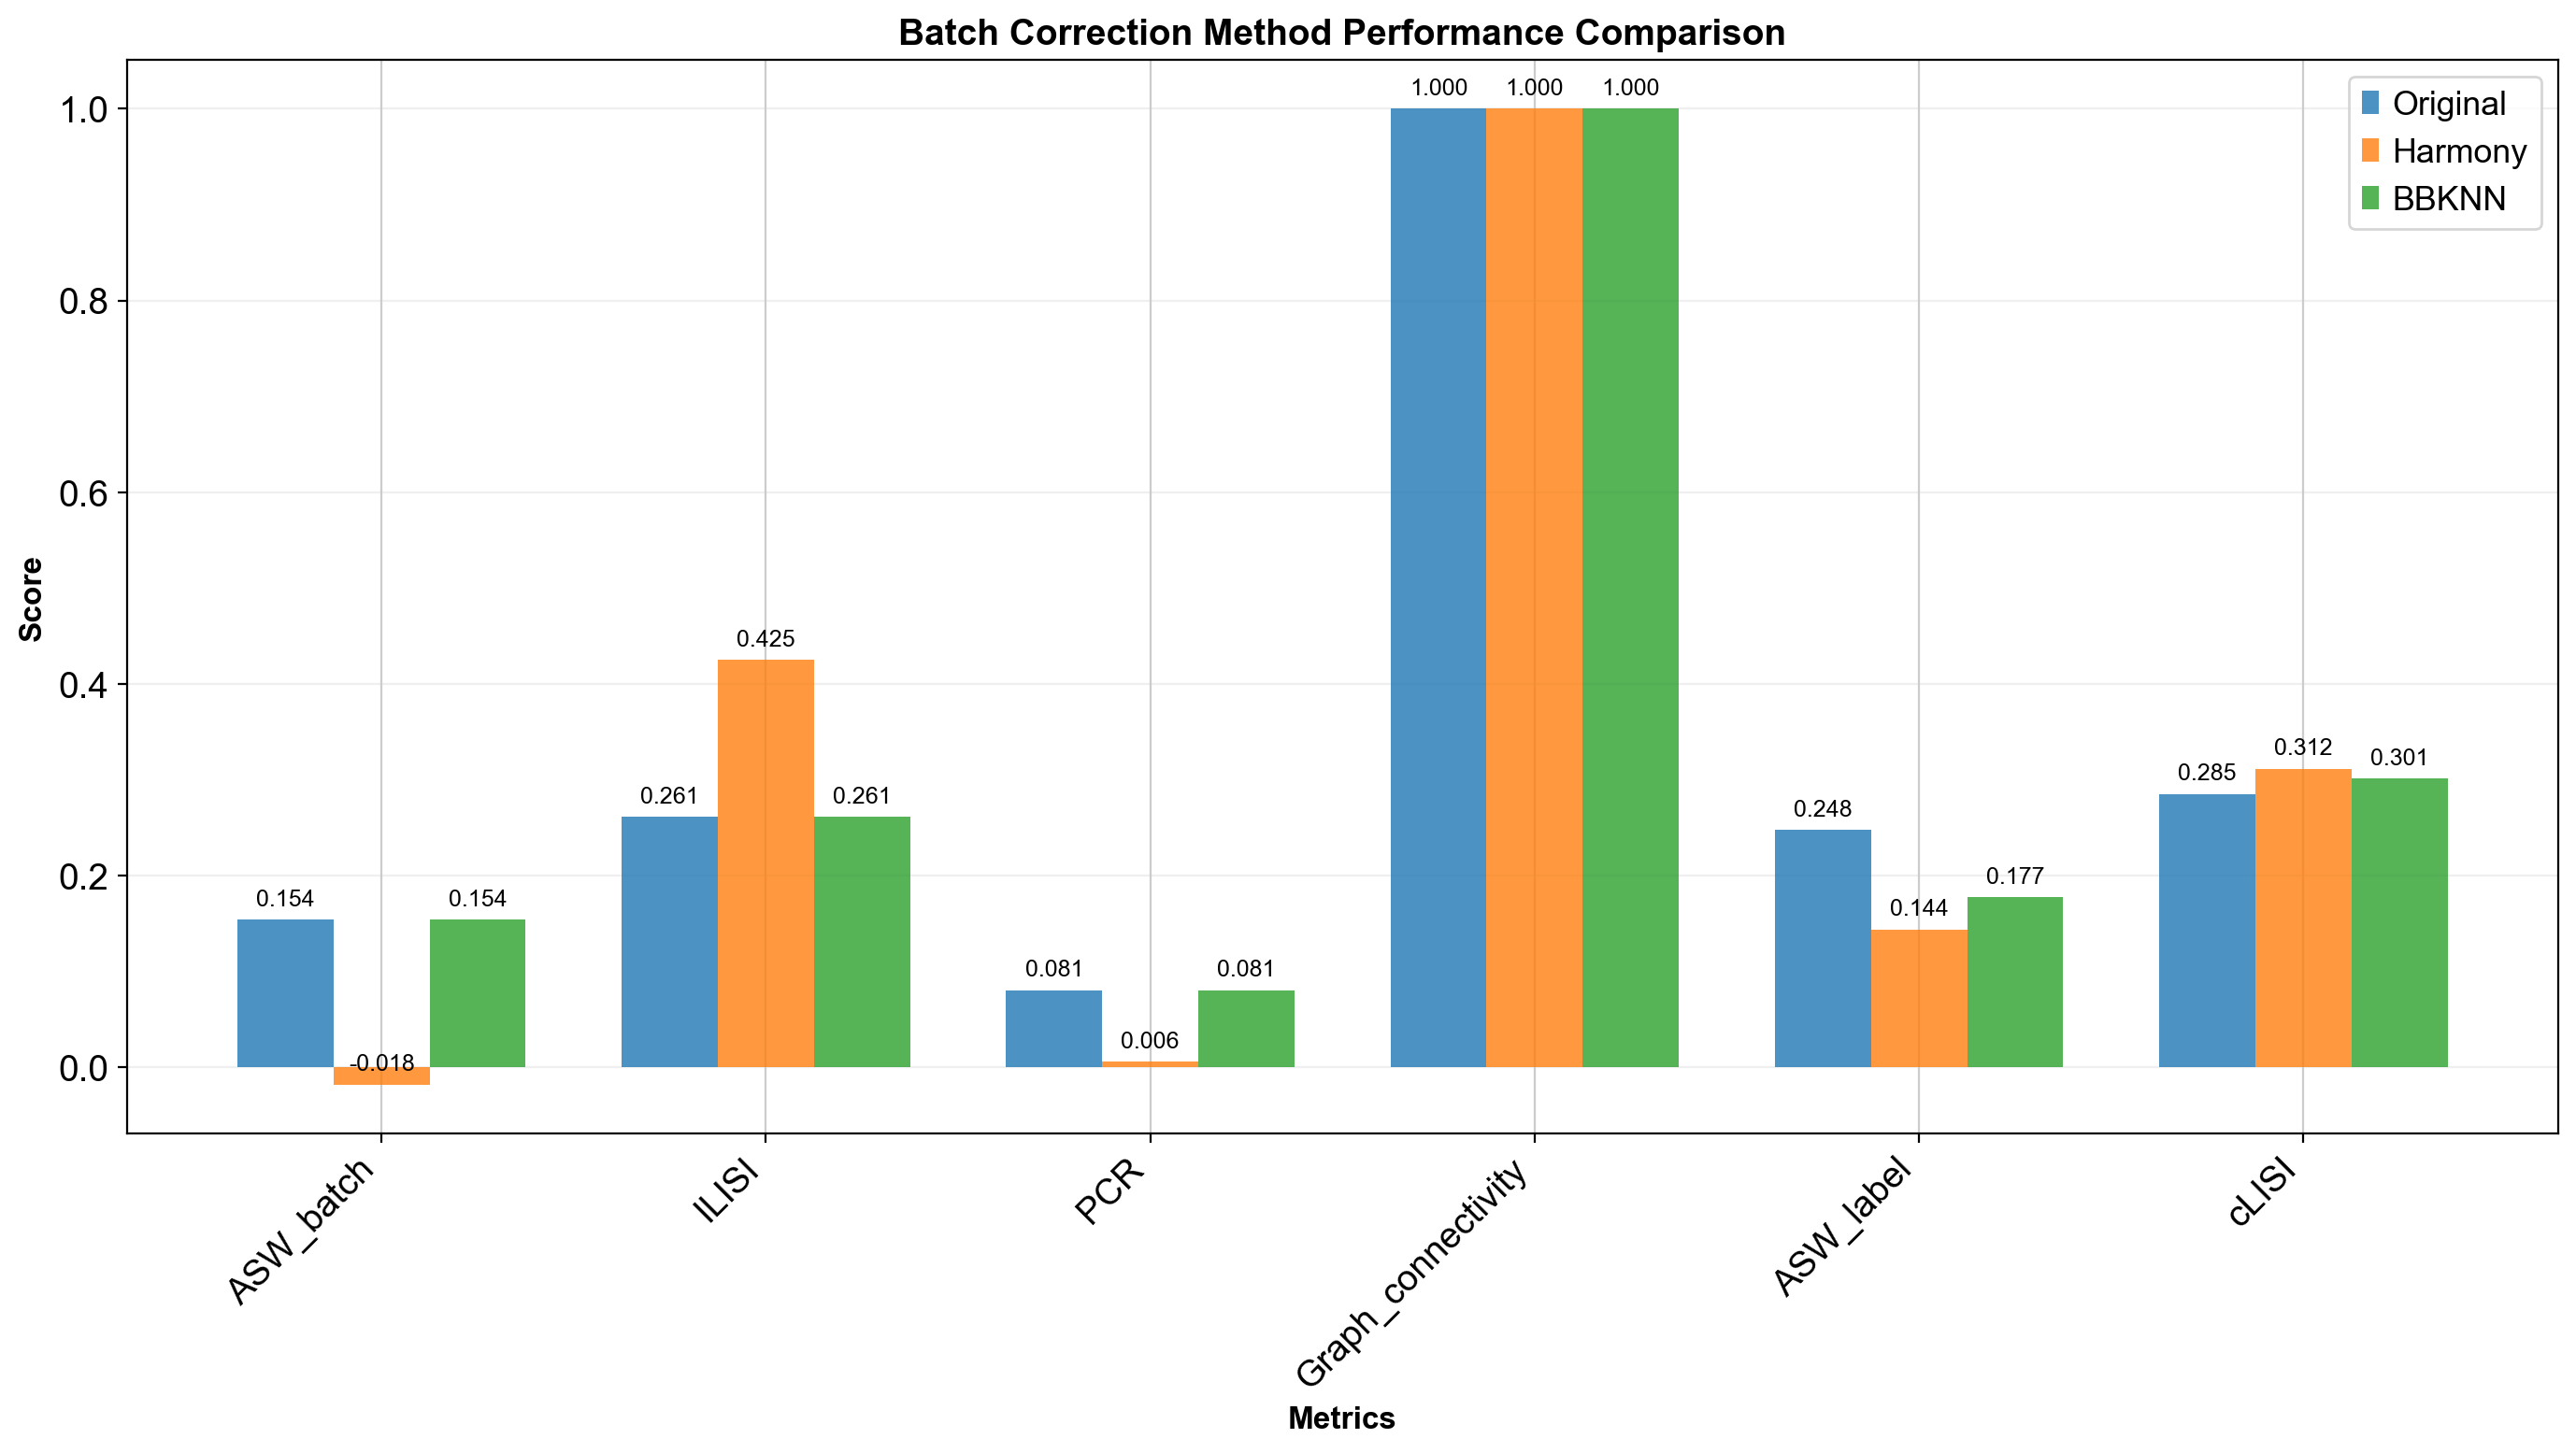

In [15]:
# Cell 12: 指标可视化比较
# Select only the metrics we want to plot
selected_metrics = ['ASW_batch', 'ILISI', 'PCR', 'Graph_connectivity', 'ASW_label', 'cLISI']
plot_df = metrics_df[selected_metrics]

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Set the width of bars and positions
bar_width = 0.25
x_pos = np.arange(len(selected_metrics))

# Create bars for each method
methods = plot_df.index
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Different colors for each method

for i, method in enumerate(methods):
    values = plot_df.loc[method].values
    ax.bar(x_pos + i * bar_width, values, bar_width, label=method, 
            alpha=0.8, color=colors[i % len(colors)])

# Customize the plot
ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Batch Correction Method Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos + bar_width)
ax.set_xticklabels(selected_metrics, rotation=45, ha='right')
ax.legend()

# Add value labels on bars
for i, method in enumerate(methods):
    values = plot_df.loc[method].values
    for j, value in enumerate(values):
        ax.text(x_pos[j] + i * bar_width, value + 0.01, f'{value:.3f}', 
                ha='center', va='bottom', fontsize=9)

# Add grid for better readability
ax.grid(True, alpha=0.3, axis='y')
ax.set_axisbelow(True)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

Original: No UMAP coordinates found. Computing UMAP...
Original: UMAP computed successfully
Harmony: Found UMAP in .obsm['X_umap']
BBKNN: Found UMAP in .obsm['X_umap']


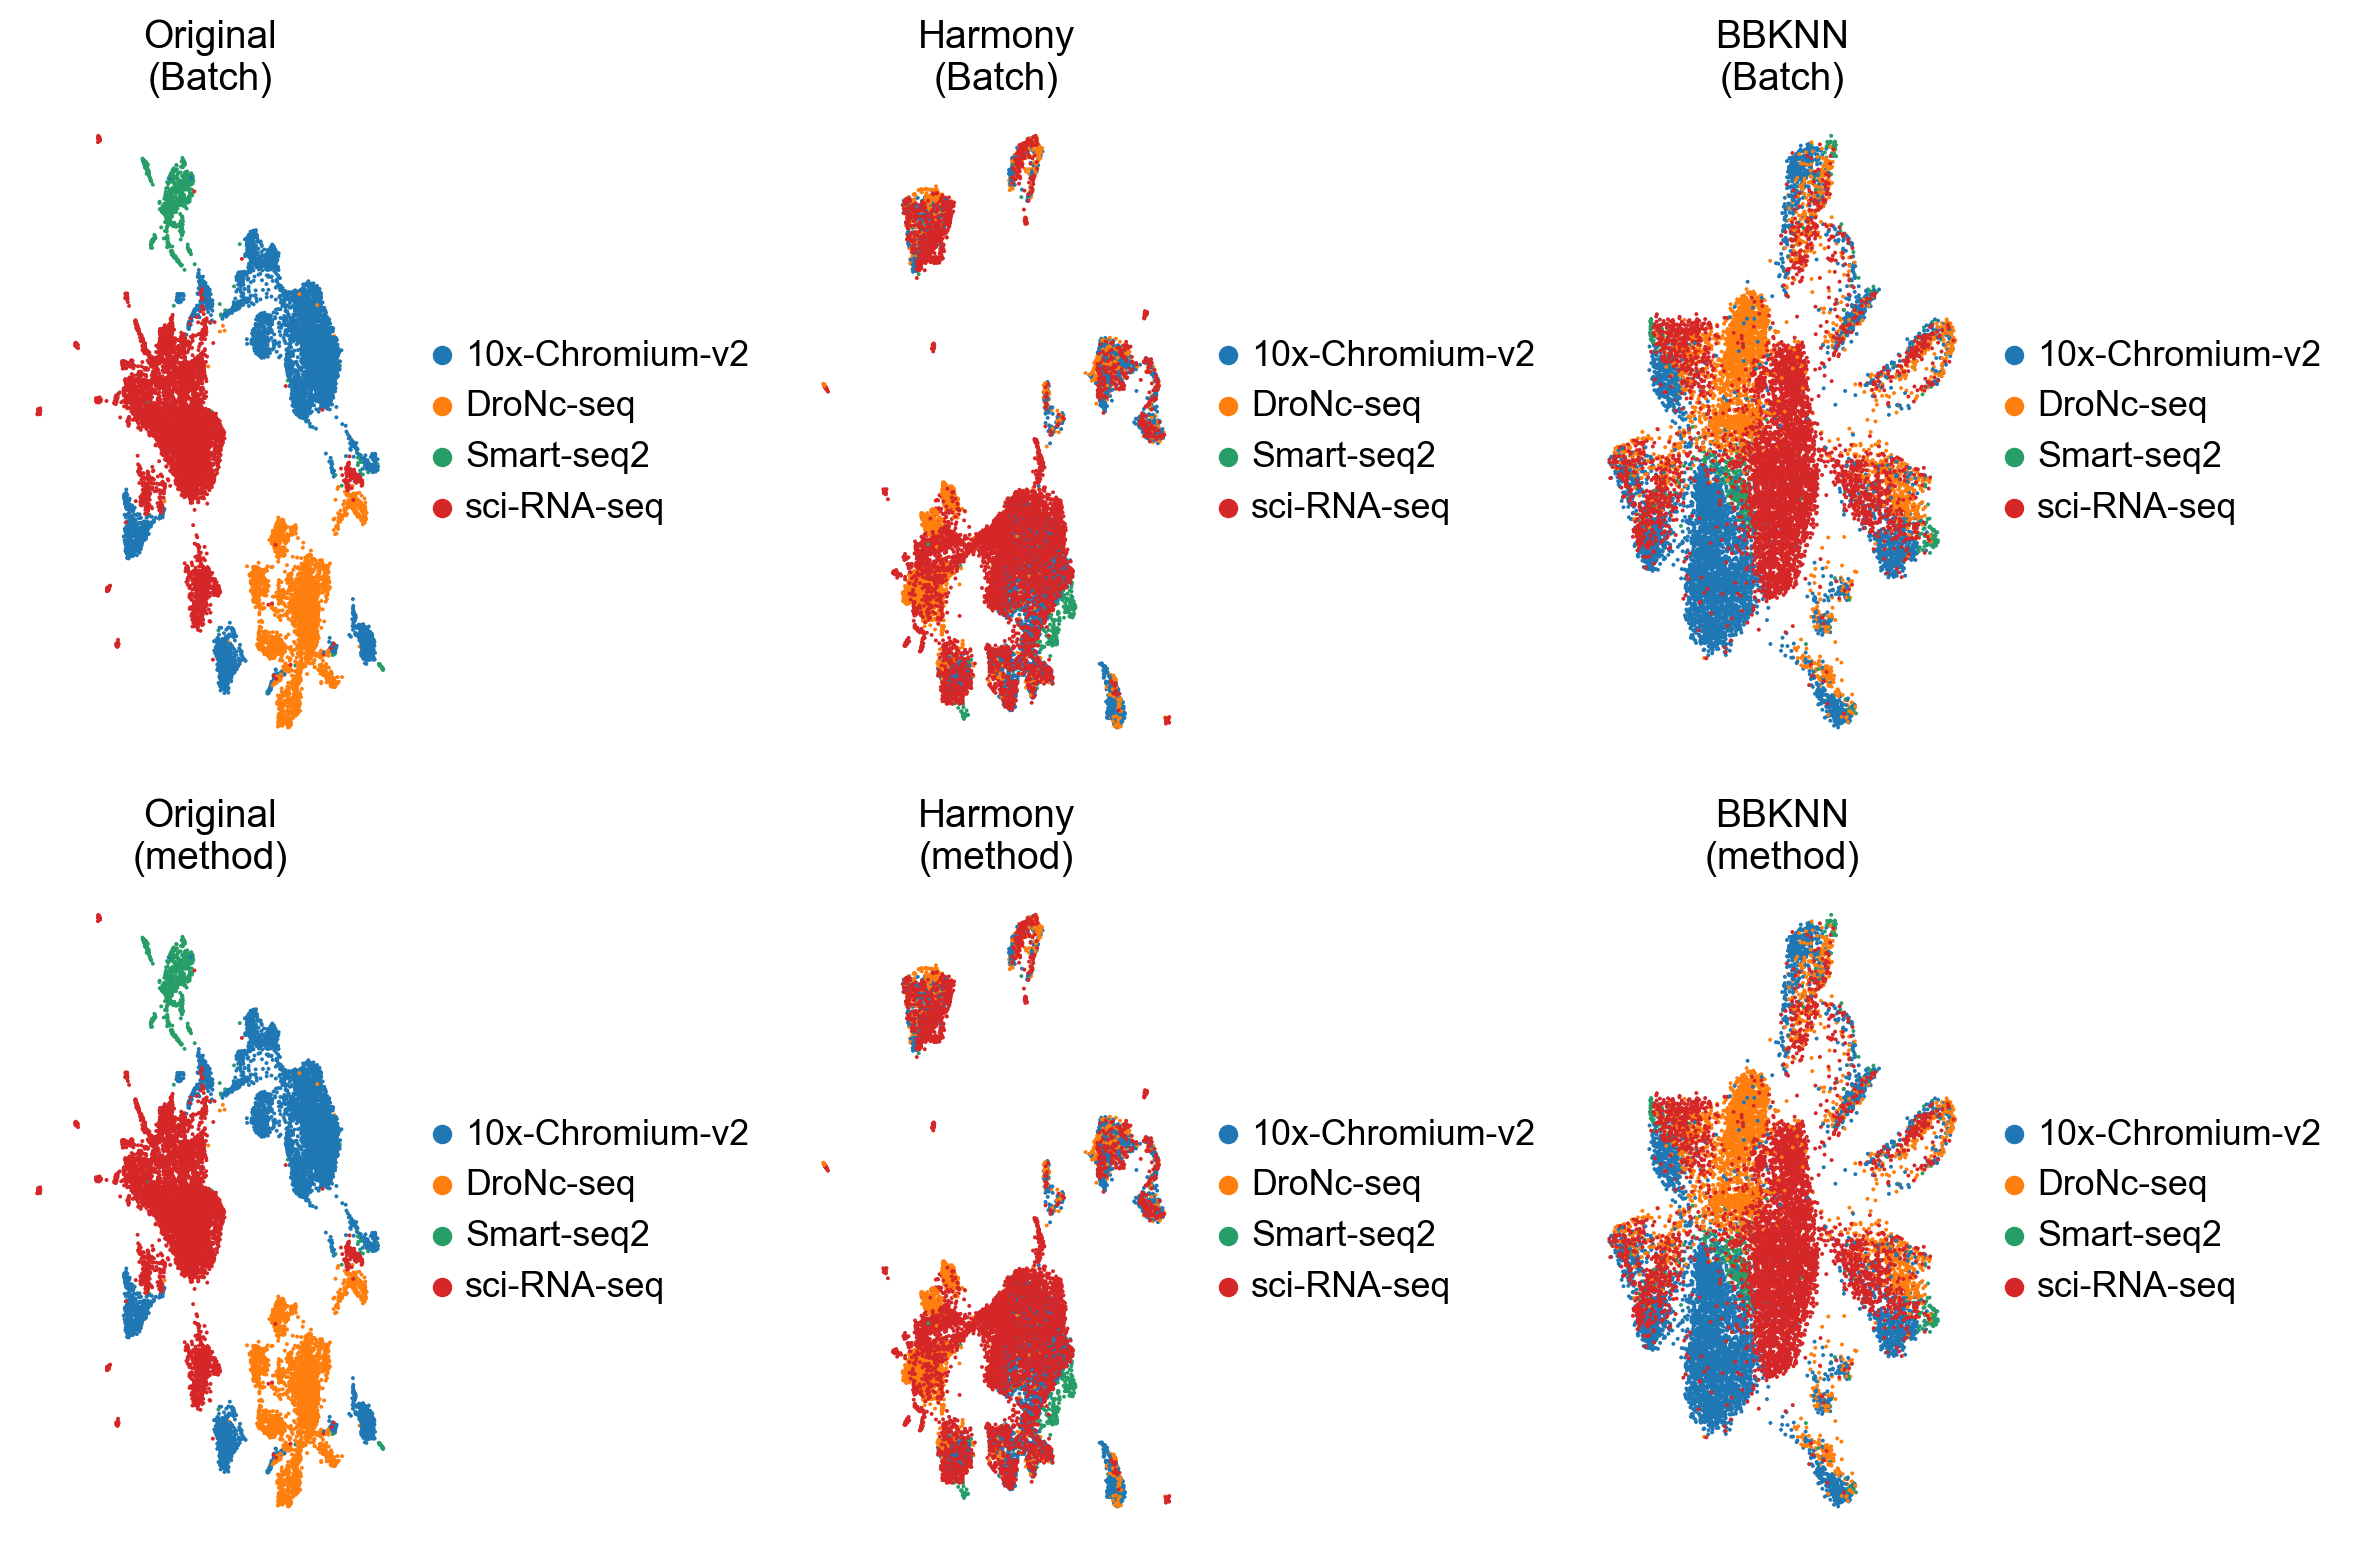

In [17]:
# Cell 13: UMAP 比较图
# 创建所有方法的UMAP比较

methods = {
    'Original': adata_processed,
    'Harmony': adata_harmony,
    'BBKNN': adata_bbknn,
}

# 检查哪些方法有UMAP坐标
available_methods = {}
for method_name, adata in methods.items():
    # 检查UMAP坐标是否存在 (可能在 'X_umap', 'umap', 或其他位置)
    umap_found = False
    possible_keys = ['X_umap', 'umap', 'UMAP']
    
    for key in possible_keys:
        if key in adata.obsm.keys():
            print(f"{method_name}: Found UMAP in .obsm['{key}']")
            umap_found = True
            break
    
    if umap_found:
        available_methods[method_name] = adata
    else:
        print(f"{method_name}: No UMAP coordinates found. Computing UMAP...")
        # 如果没有找到UMAP，计算它
        try:
            sc.pp.neighbors(adata, random_state=42)
            sc.tl.umap(adata, random_state=42)
            available_methods[method_name] = adata
            print(f"{method_name}: UMAP computed successfully")
        except Exception as e:
            print(f"{method_name}: Failed to compute UMAP - {e}")

# 只对有可用数据的方法创建图表
n_methods = len(available_methods)
if n_methods > 0:
    fig, axes = plt.subplots(2, n_methods, figsize=(4 * n_methods, 8))
    
    if n_methods == 1:
        axes = axes.reshape(2, 1)  # 确保单列时的维度正确
    
    # 第一行：按批次着色
    for i, (method_name, method_adata) in enumerate(available_methods.items()):
        sc.pl.umap(method_adata, color=['batch'], ax=axes[0, i], show=False, 
                  title=f'{method_name}\n(Batch)', frameon=False)
        axes[0, i].set_xlabel('UMAP1')
        axes[0, i].set_ylabel('UMAP2')
    
    # 第二行：按细胞类型着色（如果有）
    cell_type_available = False
    for adata in available_methods.values():
        if 'cell_type' in adata.obs.columns:
            cell_type_available = True
            break
    
    if cell_type_available:
        for i, (method_name, method_adata) in enumerate(available_methods.items()):
            if 'cell_type' in method_adata.obs.columns:
                sc.pl.umap(method_adata, color=['cell_type'], ax=axes[1, i], show=False, 
                          title=f'{method_name}\n(Cell Type)', frameon=False)
            else:
                # 如果某个数据集没有cell_type，显示提示
                axes[1, i].text(0.5, 0.5, 'No cell type\ninformation', 
                               ha='center', va='center', transform=axes[1, i].transAxes)
                axes[1, i].set_xticks([])
                axes[1, i].set_yticks([])
            axes[1, i].set_xlabel('UMAP1')
            axes[1, i].set_ylabel('UMAP2')
    else:
        # 如果没有细胞类型信息，用其他可用变量或留空
        for i, (method_name, method_adata) in enumerate(available_methods.items()):
            # 尝试找到其他可用的观察变量
            available_vars = [col for col in method_adata.obs.columns 
                             if col != 'batch' and pd.api.types.is_categorical_dtype(method_adata.obs[col])]
            
            if available_vars:
                color_var = available_vars[0]  # 使用第一个可用的分类变量
                sc.pl.umap(method_adata, color=[color_var], ax=axes[1, i], show=False, 
                          title=f'{method_name}\n({color_var})', frameon=False)
            else:
                # 如果没有其他分类变量，显示UMAP（无着色）
                sc.pl.umap(method_adata, color=None, ax=axes[1, i], show=False, 
                          title=f'{method_name}\n(UMAP only)', frameon=False)
            
            axes[1, i].set_xlabel('UMAP1')
            axes[1, i].set_ylabel('UMAP2')
    
    plt.tight_layout()
    plt.show()
else:
    print("No methods with UMAP coordinates available for plotting.")

In [ ]:
# Cell 14: 结果总结和保存
print("=== 批次效应分析总结 ===")
print(f"数据集: GSE132044 小鼠皮层")
print(f"细胞数量: {adata_processed.n_obs}")
print(f"基因数量: {adata_processed.n_vars}")
print(f"批次数量: {adata_processed.obs['batch'].nunique()}")

if 'cell_type' in adata_processed.obs.columns:
    print(f"细胞类型数量: {adata_processed.obs['cell_type'].nunique()}")

print("\n=== 各方法性能总结 ===")

# 找出每个指标的最佳方法
for metric in metrics_df.columns:
    if 'batch' in metric:  # 批次效应指标，值越小越好
        best_method = metrics_df[metric].idxmin()
        best_value = metrics_df[metric].min()
        print(f"{metric}: 最佳方法 = {best_method} (值 = {best_value:.4f})")
    else:  # 生物学保护指标，值越大越好
        best_method = metrics_df[metric].idxmax()
        best_value = metrics_df[metric].max()
        print(f"{metric}: 最佳方法 = {best_method} (值 = {best_value:.4f})")

# 保存结果
print("\n保存结果...")
metrics_df.to_csv('GSE132044_batch_integration_metrics.csv')

# 保存处理后的数据
adata_processed.write('GSE132044_processed.h5ad')
adata_harmony.write('GSE132044_harmony.h5ad')
adata_scvi.write('GSE132044_scvi.h5ad')
adata_bbknn.write('GSE132044_bbknn.h5ad')
adata_scanorama.write('GSE132044_scanorama.h5ad')

print("分析完成! 结果已保存到当前目录")